In [2]:
## Initial Analysis of Low Grade (IDH1 Mutant) Glioma basic data from NIH NCI GDC Data Portal

# Load Packages for managing and plotting data
# If using local environment may need to install using command-line, like "pip install scikit-learn"

import os
import requests
import json
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns #visualization
import matplotlib.pyplot as plt #visualization
import sklearn

%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as py
import plotly.express as px

In [147]:
# Discovery fields mapping for cases endpoint, as want to match on ssm/ gene symbol
# Can also use GDC Data Dictionary Viewer at https://docs.gdc.cancer.gov/Data_Dictionary/viewer/

url_main = "https://api.gdc.cancer.gov/"
endpoint = "genes/_mapping"
endpoint_url = url_main + endpoint
params = {"pretty":True}

response = requests.get(endpoint_url, params = params)

# View output
print(response.url)
print(json.dumps(response.json(), indent=2))

https://api.gdc.cancer.gov/genes/_mapping?pretty=True
{
  "_mapping": {
    "gene_centrics.biotype": {
      "description": "",
      "doc_type": "gene_centrics",
      "field": "biotype",
      "full": "gene_centrics.biotype",
      "type": "keyword"
    },
    "gene_centrics.canonical_transcript_id": {
      "description": "",
      "doc_type": "gene_centrics",
      "field": "canonical_transcript_id",
      "full": "gene_centrics.canonical_transcript_id",
      "type": "keyword"
    },
    "gene_centrics.canonical_transcript_length": {
      "description": "",
      "doc_type": "gene_centrics",
      "field": "canonical_transcript_length",
      "full": "gene_centrics.canonical_transcript_length",
      "type": "long"
    },
    "gene_centrics.canonical_transcript_length_cds": {
      "description": "",
      "doc_type": "gene_centrics",
      "field": "canonical_transcript_length_cds",
      "full": "gene_centrics.canonical_transcript_length_cds",
      "type": "long"
    },
    "g

In [3]:
# Example for downloading file based on UUID from GDC URL

file_endpt = 'https://api.gdc.cancer.gov/files/'
file_uuid = 'f3a1bc62-9552-4553-b318-7d9c21d21ce7'
params = {"pretty":True}

response = requests.get(file_endpt + file_uuid, params=params)

# OUTPUT METHOD 1: Write to a file.
file = open("input/sample_file.json", "w")
file.write(response.text)
file.close()

# OUTPUT METHOD 2: View on screen.
print(response.url)
print(json.dumps(response.json(), indent=2))

https://api.gdc.cancer.gov/files/f3a1bc62-9552-4553-b318-7d9c21d21ce7?pretty=True
{
  "data": {
    "data_format": "BCR Biotab",
    "access": "open",
    "file_name": "nationwidechildrens.org_clinical_patient_lgg.txt",
    "submitter_id": "nationwidechildrens.org_clinical_patient_lgg.txt",
    "data_category": "Clinical",
    "acl": [
      "open"
    ],
    "type": "clinical_supplement",
    "file_size": 351218,
    "created_datetime": "2018-05-21T22:14:34.066432-05:00",
    "md5sum": "00dcd9b02d7bdc39909d4b05072a53fa",
    "updated_datetime": "2018-11-01T15:06:10.843096-05:00",
    "file_id": "f3a1bc62-9552-4553-b318-7d9c21d21ce7",
    "data_type": "Clinical Supplement",
    "state": "released",
    "version": "1",
    "data_release": "12.0 - 36.0"
  },
  "warnings": {}
}


In [30]:
# Filtered Query via GDC using cases endpoint

# Build query criteria to match
filters = {
    "op": "and",
    "content":[
        {
        "op": "in",
        "content":{
            "field": "cases.primary_site",
            "value": ["Brain"]
            }
        },
        {
        "op": "in",
        "content":{
            "field": "cases.disease_type",
            "value": ["Gliomas"]
            }
        },
        {
        "op": "in",
        "content":{
            "field": "project.project_id",
            "value": ["CPTAC-3", "TCGA-GBM", "TCGA-LGG"]
            }
        }, # TODO: Add somatic gene symbol to query
        { 
        "op": "is",
        "content":{
            #"field": "cases.follow_ups.molecular_tests.gene_symbol", # For querying clinical data, but data is only in HCMI-CMDC
            "field": "files.index_files.data_type", # TODO: Not working against bioinformatic data, try ssms or genes endpoint
            "value": ["IDH1*"]
            }
        }
    ]
}

# Specify fields GDC to return
fields = [
    "case_id",
    "demographic.gender",
    "demographic.vital_status",
    "demographic.year_of_birth",
    "demographic.year_of_death",
    "diagnoses.age_at_diagnosis",
    "diagnoses.days_to_recurrence",
    "diagnoses.primary_diagnosis", # Astrocytoma, Glioblastoma, Mixed Glioma and Oligodendroglioma
    "diagnoses.site_of_resection_or_biopsy", # Brain, Frontal lobe, Temporal lobe, Parietal lobe...
    "diagnoses.tumor_grade", # Not seeing much data, mostly "Not Reported"
    "project.project_id", # CPTAC-3, TCGA-GBM, TCGA-LGG...
    "summary.file_count"
    ]

fields = ",".join(fields)

# Build and execute GET request
cases_endpt = "https://api.gdc.cancer.gov/cases"

# With a GET request, the filters parameter needs to be converted
# from a dictionary to JSON-formatted string

params = {
    "filters": json.dumps(filters),
    "fields": fields,
    "format": "CSV",
    "size": "100"
    }

response = requests.get(cases_endpt, params = params)

# Write to a file
file = open("input/cases_query.CSV", "w")
file.write(response.text)
file.close()

# View output
print(response.url)
print(response.text)

https://api.gdc.cancer.gov/cases?filters=%7B%22op%22%3A+%22and%22%2C+%22content%22%3A+%5B%7B%22op%22%3A+%22in%22%2C+%22content%22%3A+%7B%22field%22%3A+%22cases.primary_site%22%2C+%22value%22%3A+%5B%22Brain%22%5D%7D%7D%2C+%7B%22op%22%3A+%22in%22%2C+%22content%22%3A+%7B%22field%22%3A+%22cases.disease_type%22%2C+%22value%22%3A+%5B%22Gliomas%22%5D%7D%7D%2C+%7B%22op%22%3A+%22in%22%2C+%22content%22%3A+%7B%22field%22%3A+%22project.project_id%22%2C+%22value%22%3A+%5B%22CPTAC-3%22%2C+%22TCGA-GBM%22%2C+%22TCGA-LGG%22%5D%7D%7D%2C+%7B%22op%22%3A+%22is%22%2C+%22content%22%3A+%7B%22field%22%3A+%22files.index_files.data_type%22%2C+%22value%22%3A+%5B%22IDH1%2A%22%5D%7D%7D%5D%7D&fields=case_id%2Cdemographic.gender%2Cdemographic.vital_status%2Cdemographic.year_of_birth%2Cdemographic.year_of_death%2Cdiagnoses.age_at_diagnosis%2Cdiagnoses.days_to_recurrence%2Cdiagnoses.primary_diagnosis%2Cdiagnoses.site_of_resection_or_biopsy%2Cdiagnoses.tumor_grade%2Cproject.project_id%2Csummary.file_count&format=CSV&siz

In [146]:
# Filtered Query via GDC using ssms endpoint

# Specify fields GDC to return
# NOTE: Do not specify occurrence.case.demographic.* and occurrence.case.diagnoses.* fields, as goes for 5k+ columns
fields = [
    "occurrence.case.case_id",
    "occurrence.case.project.project_id",
    "consequence.transcript.gene.symbol",
    "gene_aa_change"
    ]

fields = ",".join(fields)

# Build query criteria
filters = {
    "op": "and",
    "content":[
        {
        "op": "in",
        "content":{
            "field": "occurrence.case.project.project_id",
            "value": ["CPTAC-3", "TCGA-GBM", "TCGA-LGG"]
            }
        }, # TODO: Query on somatic gene mutation symbol (QTY should be around 425 for specified project_id list)
        { 
        "op": "=",
        "content":{
            #"field": "gene_aa_change", # Use SSMS is for querying bioinformatic data
            "field": "consequence.transcript.gene.symbol", # Use SSMS is for querying bioinformatic data
            "value": ["IDH1*"]
            }
        }
    ]
}

# With GET request, filters parameter needs to be converted from a dictionary to JSON-formatted string
params = {
    "filters": json.dumps(filters),
    "fields": fields,
    "format": "TSV",
    "size": "500"
    }

# Specify URL endpoint
endpoint = "https://api.gdc.cancer.gov/ssms"

# Execute GET request to retrieve response
response = requests.get(endpoint, params = params)

# Write to a file
file = open("input/smss_cases_query.TSV", "w")
file.write(response.text)
file.close()

# View output
print(response.url)
print(response.text)

https://api.gdc.cancer.gov/ssms?filters=%7B%22op%22%3A+%22and%22%2C+%22content%22%3A+%5B%7B%22op%22%3A+%22in%22%2C+%22content%22%3A+%7B%22field%22%3A+%22occurrence.case.project.project_id%22%2C+%22value%22%3A+%5B%22CPTAC-3%22%2C+%22TCGA-GBM%22%2C+%22TCGA-LGG%22%5D%7D%7D%2C+%7B%22op%22%3A+%22%3D%22%2C+%22content%22%3A+%7B%22field%22%3A+%22consequence.transcript.gene.symbol%22%2C+%22value%22%3A+%5B%22IDH1%2A%22%5D%7D%7D%5D%7D&fields=occurrence.case.case_id%2Coccurrence.case.project.project_id%2Cconsequence.transcript.gene.symbol%2Cgene_aa_change&format=TSV&size=500
consequence.0.transcript.gene.symbol	consequence.1.transcript.gene.symbol	consequence.2.transcript.gene.symbol	consequence.3.transcript.gene.symbol	consequence.4.transcript.gene.symbol	consequence.5.transcript.gene.symbol	consequence.6.transcript.gene.symbol	consequence.7.transcript.gene.symbol	gene_aa_change.0	id	occurrence.0.case.case_id	occurrence.0.case.project.project_id	occurrence.1.case.case_id	occurrence.1.case.project

In [160]:
# Filtered Query via GDC using genes endpoint

# Specify fields GDC to return
# NOTE: Do not specify occurrence.case.demographic.* and occurrence.case.diagnoses.* fields, as goes for 5k+ columns
fields = [
    "case.case_id",
    "case.project.project_id",
    "symbol"
    ]

fields = ",".join(fields)

# Build query criteria
filters = {
    "op": "and",
    "content":[
        {
        "op": "in",
        "content":{
            "field": "case.primary_site",
            "value": ["Brain"]
            }
        },
        {
        "op": "in",
        "content":{
            "field": "case.disease_type",
            "value": ["Gliomas"]
            }
        },
        {
        "op": "in",
        "content":{
            "field": "case.project.project_id",
            "value": ["CPTAC-3", "TCGA-GBM", "TCGA-LGG"]
            }
        }, # TODO: Query on somatic gene mutation symbol (QTY should be around 425 for specified project_id list)
        { 
        "op": "=",
        "content":{
            #"field": "gene_aa_change", # Use SSMS is for querying bioinformatic data
            "field": "symbol", # Use SSMS is for querying bioinformatic data
            "value": ["IDH1"]
            }
        }
    ]
}

# With GET request, filters parameter needs to be converted from a dictionary to JSON-formatted string
params = {
    "filters": json.dumps(filters),
    "fields": fields,
    "format": "TSV",
    "size": "500"
    }

# Specify URL endpoint
endpoint = "https://api.gdc.cancer.gov/genes"

# Execute GET request to retrieve response
response = requests.get(endpoint, params = params)

# Write to a file
file = open("input/genes_cases_query.TSV", "w")
file.write(response.text)
file.close()

# View output
print(response.url)
print(response.text)

https://api.gdc.cancer.gov/genes?filters=%7B%22op%22%3A+%22and%22%2C+%22content%22%3A+%5B%7B%22op%22%3A+%22in%22%2C+%22content%22%3A+%7B%22field%22%3A+%22case.primary_site%22%2C+%22value%22%3A+%5B%22Brain%22%5D%7D%7D%2C+%7B%22op%22%3A+%22in%22%2C+%22content%22%3A+%7B%22field%22%3A+%22case.disease_type%22%2C+%22value%22%3A+%5B%22Gliomas%22%5D%7D%7D%2C+%7B%22op%22%3A+%22in%22%2C+%22content%22%3A+%7B%22field%22%3A+%22case.project.project_id%22%2C+%22value%22%3A+%5B%22CPTAC-3%22%2C+%22TCGA-GBM%22%2C+%22TCGA-LGG%22%5D%7D%7D%2C+%7B%22op%22%3A+%22%3D%22%2C+%22content%22%3A+%7B%22field%22%3A+%22symbol%22%2C+%22value%22%3A+%5B%22IDH1%22%5D%7D%7D%5D%7D&fields=case.case_id%2Ccase.project.project_id%2Csymbol&format=TSV&size=500
case.0.case_id	case.1.case_id	case.10.case_id	case.100.case_id	case.1000.case_id	case.1001.case_id	case.1002.case_id	case.1003.case_id	case.1004.case_id	case.1005.case_id	case.1006.case_id	case.1007.case_id	case.1008.case_id	case.1009.case_id	case.101.case_id	case.1010.case

In [2]:
# Data files managed in the "input" directory

for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


input/cases.2023-03-16.json
input/cases.2023-03-16_original.json


In [3]:
# Read JSON and Normalize/ Flatten, from https://portal.gdc.cancer.gov where Primary Site = 'brain' and Gene = 'IDH1'

data = ""
with open('input/cases.2023-03-16.json', 'r') as f:
  data = json.load(f)

data_norm = pd.json_normalize(data)

data_norm.head()


,primary_site,submitter_id,summary.file_count,summary.data_categories,diagnoses.age_at_diagnosis,diagnoses.primary_diagnosis,demographic.gender,demographic.race,demographic.vital_status,demographic.days_to_death
0,Brain,TCGA-E1-A7YY,62,"[{'file_count': 8, 'data_category': 'Copy Numb...",9867.0,"Oligodendroglioma, NOS",female,white,Dead,4445.0
1,Brain,TCGA-E1-A7Z6,62,"[{'file_count': 8, 'data_category': 'Copy Numb...",14985.0,"Astrocytoma, NOS",female,white,Dead,984.0
2,Brain,TCGA-DU-8168,62,"[{'file_count': 8, 'data_category': 'Copy Numb...",20136.0,"Oligodendroglioma, anaplastic",female,white,Alive,NaN
3,Brain,TCGA-16-0850,49,"[{'file_count': 8, 'data_category': 'Copy Numb...",19281.0,Glioblastoma,female,white,Dead,498.0
4,Brain,TCGA-S9-A6TS,62,"[{'file_count': 8, 'data_category': 'Copy Numb...",17857.0,"Astrocytoma, anaplastic",female,white,Dead,1891.0


In [4]:
# Drop summary.data_categories and rename columns

data_new = data_norm.drop(columns=['summary.data_categories'])
data_new = data_new.rename(columns={
    "summary.file_count": "file_count", 
    "diagnoses.age_at_diagnosis": "age_at_diagnosis",
    "diagnoses.primary_diagnosis": "primary_diagnosis", 
    "demographic.gender": "gender", 
    "demographic.race": "race", 
    "demographic.vital_status": "vital_status",
    "demographic.days_to_death": "days_to_death"})

data_new.head()


,primary_site,submitter_id,file_count,age_at_diagnosis,primary_diagnosis,gender,race,vital_status,days_to_death
0,Brain,TCGA-E1-A7YY,62,9867.0,"Oligodendroglioma, NOS",female,white,Dead,4445.0
1,Brain,TCGA-E1-A7Z6,62,14985.0,"Astrocytoma, NOS",female,white,Dead,984.0
2,Brain,TCGA-DU-8168,62,20136.0,"Oligodendroglioma, anaplastic",female,white,Alive,NaN
3,Brain,TCGA-16-0850,49,19281.0,Glioblastoma,female,white,Dead,498.0
4,Brain,TCGA-S9-A6TS,62,17857.0,"Astrocytoma, anaplastic",female,white,Dead,1891.0


In [5]:
# Convert age_at_diagnosis and days_to_death to year value

data_new['age_at_diagnosis'] = (data_new['age_at_diagnosis']/365.25).round(1)
data_new['overall_survival'] = (data_new['days_to_death']/365.25).round(1)
data_new.head(10)

,primary_site,submitter_id,file_count,age_at_diagnosis,primary_diagnosis,gender,race,vital_status,days_to_death,overall_survival
0,Brain,TCGA-E1-A7YY,62,27.0,"Oligodendroglioma, NOS",female,white,Dead,4445.0,12.2
1,Brain,TCGA-E1-A7Z6,62,41.0,"Astrocytoma, NOS",female,white,Dead,984.0,2.7
2,Brain,TCGA-DU-8168,62,55.1,"Oligodendroglioma, anaplastic",female,white,Alive,NaN,NaN
3,Brain,TCGA-16-0850,49,52.8,Glioblastoma,female,white,Dead,498.0,1.4
4,Brain,TCGA-S9-A6TS,62,48.9,"Astrocytoma, anaplastic",female,white,Dead,1891.0,5.2
5,Brain,C3L-02984,39,34.1,Glioblastoma,male,asian,Alive,NaN,NaN
6,Brain,TCGA-DU-6410,63,56.3,"Oligodendroglioma, anaplastic",male,white,Alive,NaN,NaN
7,Brain,TCGA-FG-A60K,63,34.1,Mixed glioma,female,white,Alive,NaN,NaN
8,Brain,TCGA-S9-A6U8,61,24.8,"Astrocytoma, NOS",male,white,Dead,2988.0,8.2
9,Brain,TCGA-DH-A7UU,61,43.9,"Astrocytoma, anaplastic",male,white,Alive,NaN,NaN


In [6]:
# Handle NaN items

data_new["days_to_death"].fillna(0, inplace=True)
data_new["overall_survival"].fillna(0, inplace=True)
data_new = data_new.dropna()

data_new.tail(10)

,primary_site,submitter_id,file_count,age_at_diagnosis,primary_diagnosis,gender,race,vital_status,days_to_death,overall_survival
415,Brain,TCGA-E1-A7YV,63,26.1,Mixed glioma,female,white,Dead,987.0,2.7
416,Brain,TCGA-FG-A6J3,66,52.4,"Astrocytoma, anaplastic",female,white,Alive,0.0,0.0
417,Brain,TCGA-S9-A6UB,61,52.6,"Oligodendroglioma, NOS",male,white,Alive,0.0,0.0
418,Brain,TCGA-HT-A614,62,47.6,Mixed glioma,male,white,Alive,0.0,0.0
419,Brain,TCGA-F6-A8O4,62,44.4,"Astrocytoma, NOS",male,asian,Alive,0.0,0.0
420,Brain,TCGA-HT-8106,63,53.5,"Astrocytoma, anaplastic",male,white,Alive,0.0,0.0
421,Brain,TCGA-FG-A60L,62,34.4,"Astrocytoma, NOS",female,white,Alive,0.0,0.0
422,Brain,TCGA-TM-A84S,62,36.8,"Oligodendroglioma, anaplastic",male,white,Alive,0.0,0.0
423,Brain,TCGA-QH-A86X,62,33.9,"Oligodendroglioma, NOS",male,white,Alive,0.0,0.0
424,Brain,TCGA-S9-A7R4,62,46.9,"Astrocytoma, anaplastic",male,white,Alive,0.0,0.0


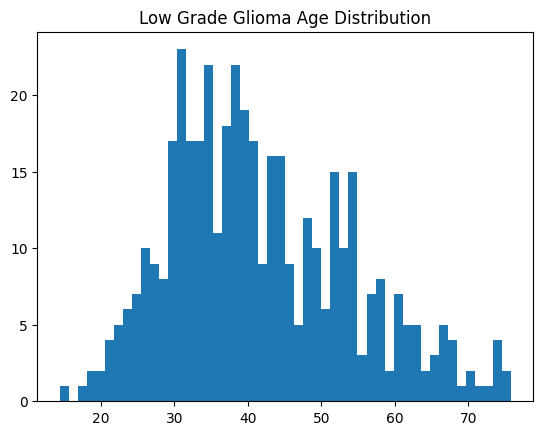

In [7]:
# Basic plot of low grade gliomas by age at diagnosis

age = data_new["age_at_diagnosis"]
plt.hist(age, bins = 50)
plt.title('Low Grade Glioma Age Distribution')
plt.show()


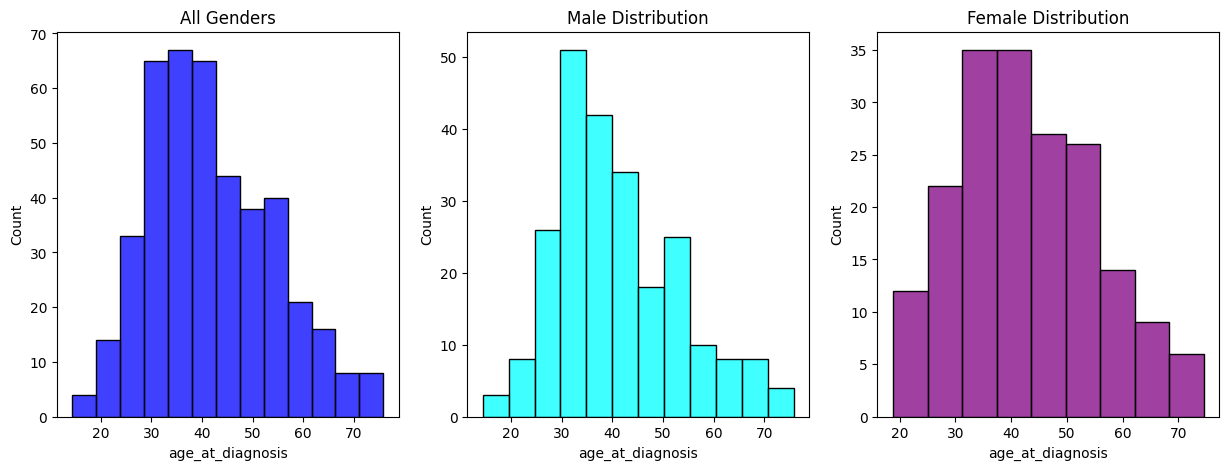

In [8]:
# Distribution by Gender using Seaborn

fig , ax = plt.subplots(1,3, figsize = (15,5))

gender_male = data_new.query("gender == 'male'")["age_at_diagnosis"]
gender_female = data_new.query("gender == 'female'")["age_at_diagnosis"]
age = data_new["age_at_diagnosis"]

sns.histplot(age , ax = ax[0] , color = 'blue').set_title('All Genders' , fontsize = 12)
sns.histplot(gender_male , ax = ax[1] , color = 'cyan').set_title('Male Distribution' , fontsize = 12)
sns.histplot(gender_female , ax = ax[2] , color = 'purple').set_title('Female Distribution' , fontsize = 12)

plt.show()

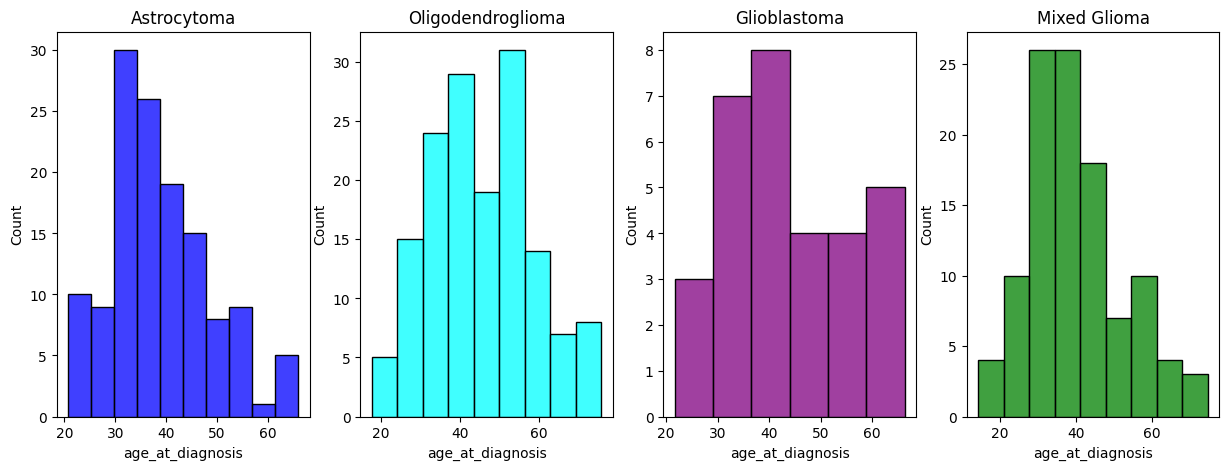

In [9]:
# Age at diagnosis distribution by glioma type (primary diagnosis)

fig , ax = plt.subplots(1,4, figsize = (15,5))

astrocytoma = data_new.query("primary_diagnosis == 'Astrocytoma, NOS' | primary_diagnosis == 'Astrocytoma, anaplastic'")["age_at_diagnosis"]
oligodendroglioma = data_new.query("primary_diagnosis == 'Oligodendroglioma, NOS' | primary_diagnosis == 'Oligodendroglioma, anaplastic'")["age_at_diagnosis"]
glioblastoma = data_new.query("primary_diagnosis == 'Glioblastoma'")["age_at_diagnosis"]
mixed_glioma = data_new.query("primary_diagnosis == 'Mixed glioma'")["age_at_diagnosis"]

sns.histplot(astrocytoma , ax = ax[0] , color = 'blue').set_title('Astrocytoma' , fontsize = 12)
sns.histplot(oligodendroglioma , ax = ax[1] , color = 'cyan').set_title('Oligodendroglioma' , fontsize = 12)
sns.histplot(glioblastoma , ax = ax[2] , color = 'purple').set_title('Glioblastoma' , fontsize = 12)
sns.histplot(mixed_glioma , ax = ax[3] , color = 'green').set_title('Mixed Glioma' , fontsize = 12)

plt.show()

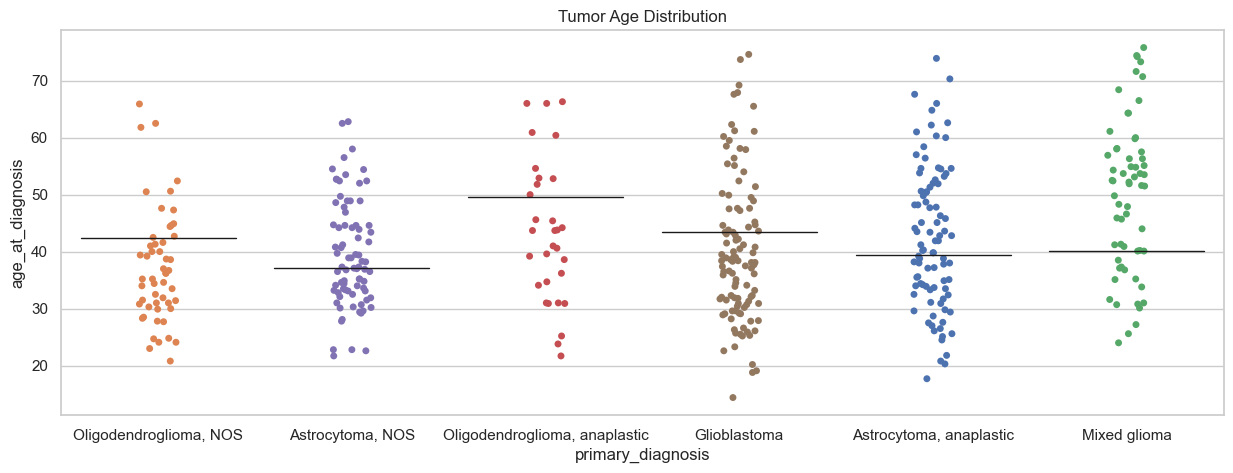

In [10]:
# Stripplot of Age by Primary Diagnosis

sns.set(style="whitegrid")
fig , ax = plt.subplots(1,1, figsize = (15,5))
  
# Seaborn stripplot w/ order by glioma type from left to right
ax = sns.stripplot(x='primary_diagnosis', y='age_at_diagnosis', hue="primary_diagnosis", data=data_new, legend=False, jitter=0.1, 
                   order=['Astrocytoma, NOS', 'Astrocytoma, anaplastic', 'Glioblastoma', 'Mixed glioma', 'Oligodendroglioma, NOS', 'Oligodendroglioma, anaplastic'])
  
# Title for plot
plt.title('Tumor Age Distribution')

# Add mean line to plot
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="primary_diagnosis",
            y="age_at_diagnosis",
            data=data_new,
            showfliers=False,
            showbox=False,
            showcaps=False)
  
# Draw plot
plt.show()

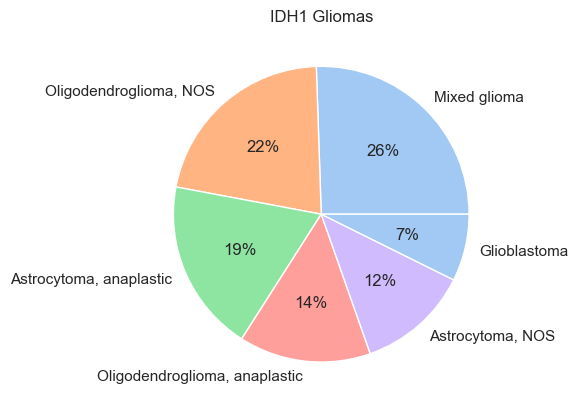

In [11]:
# Pie chart showing distribution of primary diagnosis

colors = sns.color_palette('pastel')[0:5]
data_diag = data_new["primary_diagnosis"]

plt.pie(data_diag.value_counts(), labels = data_diag.value_counts().index, colors = colors, autopct='%.0f%%')
plt.title("IDH1 Gliomas", fontsize=12);
plt.show()

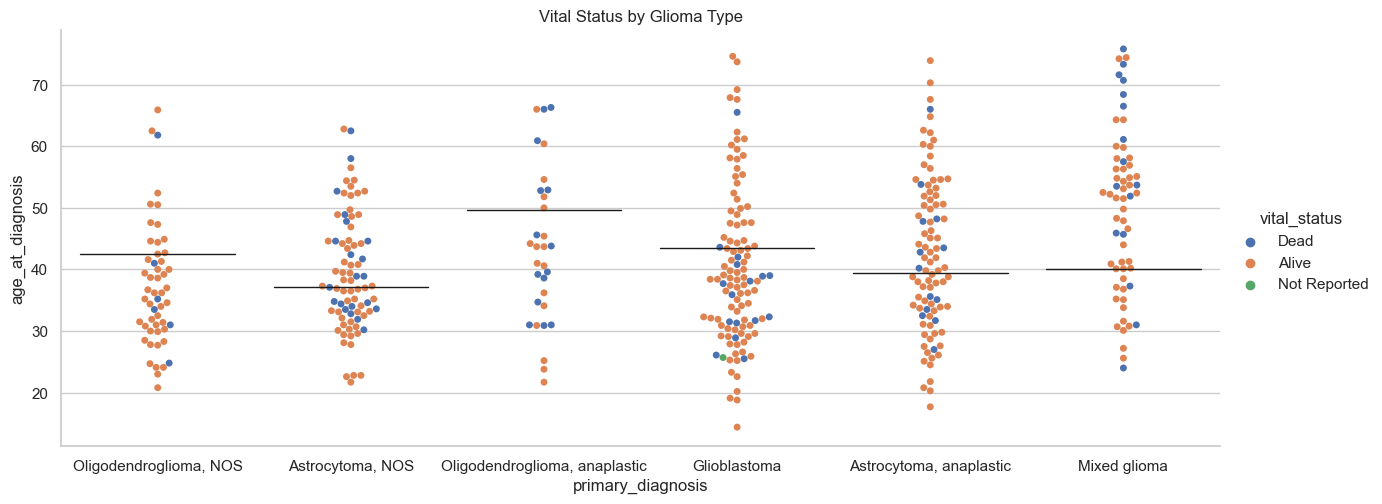

In [12]:
# Category Plot of Age and Vital Status by Primary Diagnosis

sns.set(style="whitegrid")
  
# Seaborn catplot w/ order by glioma type from left to right
ax = sns.catplot(data=data_new, kind="swarm", x='primary_diagnosis', y='age_at_diagnosis', hue="vital_status", legend=True, height=5, aspect=2.5,
                   order=['Astrocytoma, NOS', 'Astrocytoma, anaplastic', 'Glioblastoma', 'Mixed glioma', 'Oligodendroglioma, NOS', 'Oligodendroglioma, anaplastic'])

# Add mean line to plot
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="primary_diagnosis",
            y="age_at_diagnosis",
            data=data_new,
            showfliers=False,
            showbox=False,
            showcaps=False)

# Title for plot
plt.title('Vital Status by Glioma Type')
  
# Draw plot
plt.show()

In [13]:
# Compare vital_status based on primary_diagnosis

# Create dataframe with counts based on vital_status and grouped by primary_diagnosis
data_summary = data_new[["primary_diagnosis", "vital_status"]].groupby("primary_diagnosis").value_counts().reset_index(name='count')

# Calculate percentages by primary_diagnosis and truncate to two decimal places
data_summary['percent'] = 100 * (data_summary['count'] / data_summary.groupby('primary_diagnosis')['count'].transform('sum'))
data_summary['percent'] = ((data_summary['percent']*100).astype(int).astype(float))/100

data_summary


,primary_diagnosis,vital_status,count,percent
0,"Astrocytoma, NOS",Alive,46,88.46
1,"Astrocytoma, NOS",Dead,6,11.53
2,"Astrocytoma, anaplastic",Alive,59,73.75
3,"Astrocytoma, anaplastic",Dead,21,26.25
4,Glioblastoma,Alive,17,54.83
5,Glioblastoma,Dead,14,45.16
6,Mixed glioma,Alive,91,84.25
7,Mixed glioma,Dead,16,14.81
8,Mixed glioma,Not Reported,1,0.92
9,"Oligodendroglioma, NOS",Alive,78,85.71


In [14]:
# OPTIONAL: Can further breakdown by gender and also do analysis of time to death.
# As the GDC sample size is small, any conclusions would be low confidence.